In [58]:
import numpy as np
import copy

# Problem modelling imports
from docplex.mp.model import Model

# Qiskit imports
from qiskit.algorithms.minimum_eigensolvers import QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit.utils.algorithm_globals import algorithm_globals
from qiskit_optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.problems.variable import VarType
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import WarmStartQAOAOptimizer
import pandas as pd
import pickle

## Preliminaries: QUBOs


In [59]:
# Create a dictionary with the parameters of the UC

UC_dict = {}
UC_dict['pmin'] =  [10,10,20,20,25,150,25,10,150,20]                  # min power
UC_dict['pmax'] =  [55,55,130,130,162,455,85,55,455,80]                 # max power
UC_dict['A'] = [660,670,700,680,450,970,480,665,1000,370]                   # constant cost
UC_dict['B'] = [25.92,27.76,16.6,16.5,19.7,17.26,27.74,27.27,16.19,22.26]             # linear cost
UC_dict['C'] = [0.00413,0.00173,0.002,0.00211,0.00398,0.00031,0.0079,0.00222,0.00048,0.00712]      # quadratic cost
#UC_dict['lambda'] = [5*10^6,5*10^6,5000*10^6]       # penaltys for not respectig total power, max power and min power, respectively
UC_dict['L'] = 1000                                  # load
UC_dict['p'] = [10, 10, 20, 130, 25, 415, 25, 10, 455, 20]                       # power demand of each unit
UC_dict['lambda'] = [3,1,1]       # penaltys for not respectig total power, max power and min power, respectively
UC_dict['s1'] = [UC_dict['p'][i]-UC_dict['pmin'][i] for i in range(len(UC_dict['p']))]   # slack variables for min power                                     
UC_dict['s2'] = [UC_dict['pmax'][i]-UC_dict['p'][i] for i in range(len(UC_dict['p']))] 
UC_dict['units'] = '0001010010'

UC_dict_1 = {}
UC_dict_1['pmin'] =  [150,20,25,20]                   # min power
UC_dict_1['pmax'] =  [455,130,162,80]                 # max power
UC_dict_1['A'] = [1000,700,450,370]                   # constant cost
UC_dict_1['B'] = [16.19,16.5,16.7,22.26]              # linear cost
UC_dict_1['C'] = [0.00048,0.002,0.00398,0.00712]      # quadratic cost
UC_dict_1['lambda'] = [1,1,1]       # penaltys for not respectig total power, max power and min power, respectively
UC_dict_1['L'] = 550                                  # load
UC_dict_1['p'] = [455,20,95,20]                       # power demand of each unit 
UC_dict_1['s1'] = [UC_dict_1['p'][i]-UC_dict_1['pmin'][i] for i in range(len(UC_dict_1['p']))]   # slack variables for min power                                     
UC_dict_1['s2'] = [UC_dict_1['pmax'][i]-UC_dict_1['p'][i] for i in range(len(UC_dict_1['p']))] 
UC_dict_1['units'] = '1010'

UC_dict_2 = {}
UC_dict_2['pmin'] =  [200, 150, 20, 30, 25, 20, 40, 10, 15, 10]                  # min power
UC_dict_2['pmax'] =  [300, 455, 130, 130, 100, 80, 85, 55, 55, 55]                 # max power
UC_dict_2['A'] = [660,670,700,680,450,970,480,665,1000,370]                   # constant cost
UC_dict_2['B'] = [25.92,27.76,16.6,16.5,19.7,17.26,27.74,27.27,16.19,22.26]             # linear cost
UC_dict_2['C'] = [0.00413, 0.00173, 0.002, 0.00211, 0.00398, 0.00031, 0.0079, 0.00222, 0.00048, 0.00712]      # quadratic cost
#UC_dict['lambda'] = [5*10^6,5*10^6,5000*10^6]       # penaltys for not respectig total power, max power and min power, respectively
UC_dict_2['L'] = 800                                  # load
UC_dict_2['p'] = [300, 440, 130, 130, 100, 20, 40, 10, 15,55]                       # power demand of each unit
UC_dict_2['lambda'] = [3,1,1]       # penaltys for not respectig total power, max power and min power, respectively
UC_dict_2['s1'] = [UC_dict_2['p'][i]-UC_dict_2['pmin'][i] for i in range(len(UC_dict_2['p']))]   # slack variables for min power                                     
UC_dict_2['s2'] = [UC_dict_2['pmax'][i]-UC_dict_2['p'][i] for i in range(len(UC_dict_2['p']))]
UC_dict_2['units'] = '0111100000'


UC_dict_3 = {}
UC_dict_3['pmin'] =  [10,10,20,20,25,150,25,10,150,20]                  # min power
UC_dict_3['pmax'] =  [55,55,130,130,162,455,85,55,455,80]                 # max power
UC_dict_3['A'] = [660,670,700,680,450,970,480,665,1000,370]                   # constant cost
UC_dict_3['B'] = [25.92,27.76,16.6,16.5,19.7,17.26,27.74,27.27,16.19,22.26]             # linear cost
UC_dict_3['C'] = [0.00413,0.00173,0.002,0.00211,0.00398,0.00031,0.0079,0.00222,0.00048,0.00712]      # quadratic cost
#UC_dict['lambda'] = [5*10^6,5*10^6,5000*10^6]       # penaltys for not respectig total power, max power and min power, respectively
UC_dict_3['L'] = 900                                # load
UC_dict_3['p'] = [10,10,20,20,25,445,25,10,455,20]                       # power demand of each unit
UC_dict_3['lambda'] = [5,1,1]       # penaltys for not respectig total power, max power and min power, respectively
UC_dict_3['s1'] = [UC_dict_3['p'][i]-UC_dict_3['pmin'][i] for i in range(len(UC_dict_3['p']))]   # slack variables for min power                                     
UC_dict_3['s2'] = [UC_dict_3['pmax'][i]-UC_dict_3['p'][i] for i in range(len(UC_dict_3['p']))] 
UC_dict_3['units'] = '0000010010'

UC_dict_4 = {}
UC_dict_4['pmin'] =  [10,10,25,150]                   # min power
UC_dict_4['pmax'] =  [55,100,85,500]                  # max power
UC_dict_4['A'] = [670,450,735,370]                    # constant cost
UC_dict_4['B'] = [25.92,16.5,16.7,22.26]              # linear cost
UC_dict_4['C'] = [0.00413,0.002,0.00398,0.00712]       # quadratic cost
UC_dict_4['lambda'] = [1,1,1]                        # penaltys for not respectig total power, max power and min power, respectively
UC_dict_4['L'] = 400                                  # load
UC_dict_4['p'] = [10, 100, 85, 215]                       # power demand of each unit 
UC_dict_4['s1'] = [UC_dict_4['p'][i]-UC_dict_4['pmin'][i] for i in range(len(UC_dict_4['p']))]   # slack variables for min power                                     
UC_dict_4['s2'] = [UC_dict_4['pmax'][i]-UC_dict_4['p'][i] for i in range(len(UC_dict_4['p']))]
UC_dict_4['units'] = '0111'


UC_dict_5 = {}
UC_dict_5['pmin'] =  [150,20,25,20]                   # min power
UC_dict_5['pmax'] =  [455,130,162,80]                 # max power
UC_dict_5['A'] = [1000,700,450,370]                   # constant cost
UC_dict_5['B'] = [16.19,16.5,16.7,22.26]              # linear cost
UC_dict_5['C'] = [0.00048,0.002,0.00398,0.00712]      # quadratic cost
UC_dict_5['lambda'] = [30,1,1]       # penaltys for not respectig total power, max power and min power, respectively
UC_dict_5['L'] = 300                                  # load
UC_dict_5['p'] = [300,20,25,20]                       # power demand of each unit 
UC_dict_5['s1'] = [UC_dict_5['p'][i]-UC_dict_5['pmin'][i] for i in range(len(UC_dict_5['p']))]   # slack variables for min power                                     
UC_dict_5['s2'] = [UC_dict_5['pmax'][i]-UC_dict_5['p'][i] for i in range(len(UC_dict_5['p']))]
UC_dict_5['units'] = '1000'

UC_dict_6 = {}
UC_dict_6['pmin'] =  [80,30,60, 60,40,120,130,20,54,170,40,110,130,35,140,200,190,30,70,10]                  
UC_dict_6['pmax'] =  [295,370,580,150,200,500,255,615,350,640,420,220,465,445,416,375,550,80,545,420]
UC_dict_6['A'] = [430,520,785,400,880,435,350,720,930,890,870,860,980,490,725,370,450,840,415,410]
UC_dict_6['B'] = [25.08,22.67,19.82,19.08,19.68,29.95,23.26,18.04,21,24.83,21.25,24.52,15.76,15.11,29.97,20.07,20.55,24.85,23.57,16.05]
UC_dict_6['C'] = [0.00516,0.00656,0.00138,0.00273,0.00408,0.0067,0.00217,0.00197,0.0032,0.00788,0.0023,0.00083,0.00622,0.00311,0.00505,0.00608,0.00105,0.00269,0.00479,0.00048]
UC_dict_6['lambda'] = [30,1,1]
UC_dict_6['L'] = 2000
UC_dict_6['p'] = [80.0, 30.0, 60.0, 150.0, 40.0, 120.0, 130.0, 589.53, 54.0, 170.0, 40.0, 110.0, 395.47, 445.0, 140.0, 200.0, 195, 30.0, 70.0, 420.0]
UC_dict_6['units'] = '00010001000011000001'
UC_dict_6['s1'] = [UC_dict_6['p'][i]-UC_dict_6['pmin'][i] for i in range(len(UC_dict_6['p']))]   # slack variables for min power                                     
UC_dict_6['s2'] = [UC_dict_6['pmax'][i]-UC_dict_6['p'][i] for i in range(len(UC_dict_6['p']))]

UC_dict_7 = {}
UC_dict_7['pmin'] =  [80,30,60, 60,40,120,130,20,54,170,40,110,130,35,140,200,190,30,70,10]                  
UC_dict_7['pmax'] =  [295,370,580,150,200,500,255,615,350,640,420,220,465,445,416,375,550,80,545,420]
UC_dict_7['A'] = [430,520,785,400,880,435,350,720,930,890,870,860,980,490,725,370,450,840,415,410]
UC_dict_7['B'] = [25.08,22.67,19.82,19.08,19.68,29.95,23.26,18.04,21,24.83,21.25,24.52,15.76,15.11,29.97,20.07,20.55,24.85,23.57,16.05]
UC_dict_7['C'] = [0.00516,0.00656,0.00138,0.00273,0.00408,0.0067,0.00217,0.00197,0.0032,0.00788,0.0023,0.00083,0.00622,0.00311,0.00505,0.00608,0.00105,0.00269,0.00479,0.00048]
UC_dict_7['lambda'] = [30,1,1]
UC_dict_7['L'] = 4000
UC_dict_7['p'] = [80, 310.35, 580, 150.0, 194, 120, 130, 615, 54, 170, 420, 110, 465, 445, 140, 355, 550, 30, 70, 420]
UC_dict_7['units'] = '00110001001011011001' 
UC_dict_7['s1'] = [UC_dict_7['p'][i]-UC_dict_7['pmin'][i] for i in range(len(UC_dict_7['p']))]   # slack variables for min power                                     
UC_dict_7['s2'] = [UC_dict_7['pmax'][i]-UC_dict_7['p'][i] for i in range(len(UC_dict_7['p']))]

UC_dict_8 = {}
UC_dict_8['pmin'] =  [80,30,60, 60,40,120,130,20,54,170,40,110,130,35,140,200,190,30,70,10]                  
UC_dict_8['pmax'] =  [295,370,580,150,200,500,255,615,350,640,420,220,465,445,416,375,550,80,545,420]
UC_dict_8['A'] = [430,520,785,400,880,435,350,720,930,890,870,860,980,490,725,370,450,840,415,410]
UC_dict_8['B'] = [25.08,22.67,19.82,19.08,19.68,29.95,23.26,18.04,21,24.83,21.25,24.52,15.76,15.11,29.97,20.07,20.55,24.85,23.57,16.05]
UC_dict_8['C'] = [0.00516,0.00656,0.00138,0.00273,0.00408,0.0067,0.00217,0.00197,0.0032,0.00788,0.0023,0.00083,0.00622,0.00311,0.00505,0.00608,0.00105,0.00269,0.00479,0.00048]
UC_dict_8['lambda'] = [30,1,1]
UC_dict_8['L'] = 6000 
UC_dict_8['p'] = [295,370,580,150,200,120,255,615,350,550, 420,213.67,465,445,140,375,550,30,510,420]
UC_dict_8['units'] = '11111011101011011011'
UC_dict_8['s1'] = [UC_dict_8['p'][i]-UC_dict_8['pmin'][i] for i in range(len(UC_dict_8['p']))]   # slack variables for min power                                     
UC_dict_8['s2'] = [UC_dict_8['pmax'][i]-UC_dict_8['p'][i] for i in range(len(UC_dict_8['p']))] 




In [60]:
# The UC problem simplified is of the type:  
# min (20 z1 + 5 z2 + 7 z3 + 10 z4)
#. s.t. 10 z1 + 5 z2 + 5 z3 + 5 z4 = 10


Min_c = [UC_dict['A'][i] + UC_dict['B'][i]*UC_dict['p'][i]+UC_dict['C'][i]*UC_dict['p'][i]**2 for i in range (len(UC_dict['A']))]

n_vars = len(Min_c)

# build Q
Q = np.zeros ((n_vars,n_vars))

# build c
c = np.zeros (n_vars)
for i in range (n_vars):
    c[i] = Min_c[i]

In [61]:
penalty1=10
penalty2=10

def create_problem(mu: np.array, sigma: np.array, UC_dict,penalty) -> QuadraticProgram:
    
    """Solve the quadratic program using docplex."""

    mdl = Model()
    x = [mdl.binary_var("x%s" % i) for i in range(len(UC_dict['p']))]
    objective = mdl.sum([mu[i] * x[i] for i in range(len(mu))])
    #objective -= 2 * mdl.sum(
        #[sigma[i, j] * x[i] * x[j] for i in range(len(mu)) for j in range(len(mu))]
    #)
    objective += penalty * (mdl.sum([x[i] * UC_dict['p'][i] for i in range(len(UC_dict['p']))]) - UC_dict['L'])**2
    # Add penalty for pmin < p * x[i]

    for i in range(len(UC_dict['p'])):
        objective += penalty1 * (UC_dict['p'][i]* x[i] - UC_dict['s1'] [i]* x[i] - UC_dict['pmin'][i]* x[i]) ** 2
    # Add penalty for p * x[i] < pmax
    for i in range(len(UC_dict['p'])):
        objective += penalty2 * (UC_dict['s2'] [i]* x[i] + UC_dict['p'][i]* x[i] - UC_dict['pmax'][i]* x[i]) ** 2
    
    mdl.minimize(objective)

    # Add constraint sum(x[i]*p[i]) = L
    #mdl.add_constraint(mdl.sum([x[i] * UC_dict['p'][i] for i in range(len(UC_dict['p']))]) == UC_dict['L'])



    qp = from_docplex_mp(mdl)
    return qp


## Standard QAOA


In [62]:
def get_media_fval (samples):
    media_fval = 0
    for s in samples:
        media_fval += s.fval* s.probability
    return media_fval

In [63]:
def aproximation_ratio_penalty(penalty,UC_dict):
    # Create the problem
    Min_c = [UC_dict['A'][i] + UC_dict['B'][i]*UC_dict['p'][i]+UC_dict['C'][i]*UC_dict['p'][i]**2 for i in range (len(UC_dict['A']))]
    n_vars = len(UC_dict['p'])
    c = np.zeros (n_vars)
    Q=np.zeros((n_vars,n_vars))
    for i in range (n_vars):
        c[i] = Min_c[i]
    qubo = create_problem(Min_c, Q, UC_dict,penalty)
    
    # solve the problem
    algorithm_globals.random_seed = 12345
    qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA(), reps=1)
    exact_mes = NumPyMinimumEigensolver()
    qaoa = MinimumEigenOptimizer(qaoa_mes)
    qaoa_result = qaoa.solve(qubo)
    x=qaoa_result.x
    
    #convert x to string
    x_str = "".join([str(int(_)) for _ in x])
    media_fval = get_media_fval (qaoa_result.samples)
    return x_str,media_fval


In [64]:
with open ('results_table.txt', 'rb') as f:
    results_table = pickle.load(f)

# Print the results table
print(results_table)

    Penalty      Optimal Solution  Approximation Ratio
0         1            0001010010         3.037774e+05
1         2            0001010010         6.017315e+05
2         3            0001010010         8.962029e+05
3         4            0001010010         1.300693e+06
4         5            0001010010         1.492545e+06
5         6            0001010010         1.772627e+06
6         7            0001010010         2.066741e+06
7         8            0001010010         2.358132e+06
8         9            0001010010         2.702700e+06
9        10            0001010010         2.954982e+06
10       20            0001010010         5.946278e+06
11       30            0001010010         8.978649e+06
12       40            0001010010         1.208966e+07
13       50            0001010010         1.477062e+07
14       60            0001010010         1.755881e+07
15       70            0001010010         2.074956e+07
16       80            0001010010         2.478307e+07
17       9

In [65]:
# Modify the display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Your code to create the DataFrame

# Print the DataFrame
print(results_table)

    Penalty      Optimal Solution  Approximation Ratio
0         1            0001010010         3.037774e+05
1         2            0001010010         6.017315e+05
2         3            0001010010         8.962029e+05
3         4            0001010010         1.300693e+06
4         5            0001010010         1.492545e+06
5         6            0001010010         1.772627e+06
6         7            0001010010         2.066741e+06
7         8            0001010010         2.358132e+06
8         9            0001010010         2.702700e+06
9        10            0001010010         2.954982e+06
10       20            0001010010         5.946278e+06
11       30            0001010010         8.978649e+06
12       40            0001010010         1.208966e+07
13       50            0001010010         1.477062e+07
14       60            0001010010         1.755881e+07
15       70            0001010010         2.074956e+07
16       80            0001010010         2.478307e+07
17       9

## Warm-Start

In [66]:
# Create a dictionary with the parameters of the UC

UC_dict = {}
UC_dict['pmin'] =  [10,10,20,20,25,150,25,10,150,20]                  # min power
UC_dict['pmax'] =  [55,55,130,130,162,455,85,55,455,80]                 # max power
UC_dict['A'] = [660,670,700,680,450,970,480,665,1000,370]                   # constant cost
UC_dict['B'] = [25.92,27.76,16.6,16.5,19.7,17.26,27.74,27.27,16.19,22.26]             # linear cost
UC_dict['C'] = [0.00413,0.00173,0.002,0.00211,0.00398,0.00031,0.0079,0.00222,0.00048,0.00712]      # quadratic cost
#UC_dict['lambda'] = [5*10^6,5*10^6,5000*10^6]       # penaltys for not respectig total power, max power and min power, respectively
UC_dict['L'] = 1000                                  # load
UC_dict['p'] = [10, 10, 20, 130, 25, 415, 25, 10, 455, 20]                       # power demand of each unit
UC_dict['lambda'] = [3,1,1]       # penaltys for not respectig total power, max power and min power, respectively
UC_dict['s1'] = [UC_dict['p'][i]-UC_dict['pmin'][i] for i in range(len(UC_dict['p']))]   # slack variables for min power                                     
UC_dict['s2'] = [UC_dict['pmax'][i]-UC_dict['p'][i] for i in range(len(UC_dict['p']))] 
UC_dict['units'] = '0001010010'

UC_dict_1 = {}
UC_dict_1['pmin'] =  [150,20,25,20]                   # min power
UC_dict_1['pmax'] =  [455,130,162,80]                 # max power
UC_dict_1['A'] = [1000,700,450,370]                   # constant cost
UC_dict_1['B'] = [16.19,16.5,16.7,22.26]              # linear cost
UC_dict_1['C'] = [0.00048,0.002,0.00398,0.00712]      # quadratic cost
UC_dict_1['lambda'] = [1,1,1]       # penaltys for not respectig total power, max power and min power, respectively
UC_dict_1['L'] = 550                                  # load
UC_dict_1['p'] = [455,20,95,20]                       # power demand of each unit 
UC_dict_1['s1'] = [UC_dict_1['p'][i]-UC_dict_1['pmin'][i] for i in range(len(UC_dict_1['p']))]   # slack variables for min power                                     
UC_dict_1['s2'] = [UC_dict_1['pmax'][i]-UC_dict_1['p'][i] for i in range(len(UC_dict_1['p']))] 
UC_dict_1['units'] = '1010'

UC_dict_2 = {}
UC_dict_2['pmin'] =  [200, 150, 20, 30, 25, 20, 40, 10, 15, 10]                  # min power
UC_dict_2['pmax'] =  [300, 455, 130, 130, 100, 80, 85, 55, 55, 55]                 # max power
UC_dict_2['A'] = [660,670,700,680,450,970,480,665,1000,370]                   # constant cost
UC_dict_2['B'] = [25.92,27.76,16.6,16.5,19.7,17.26,27.74,27.27,16.19,22.26]             # linear cost
UC_dict_2['C'] = [0.00413, 0.00173, 0.002, 0.00211, 0.00398, 0.00031, 0.0079, 0.00222, 0.00048, 0.00712]      # quadratic cost
#UC_dict['lambda'] = [5*10^6,5*10^6,5000*10^6]       # penaltys for not respectig total power, max power and min power, respectively
UC_dict_2['L'] = 800                                  # load
UC_dict_2['p'] = [300, 440, 130, 130, 100, 80, 40, 10, 55,47]                       # power demand of each unit
UC_dict_2['lambda'] = [3,1,1]       # penaltys for not respectig total power, max power and min power, respectively
UC_dict_2['s1'] = [UC_dict_2['p'][i]-UC_dict_2['pmin'][i] for i in range(len(UC_dict_2['p']))]   # slack variables for min power                                     
UC_dict_2['s2'] = [UC_dict_2['pmax'][i]-UC_dict_2['p'][i] for i in range(len(UC_dict_2['p']))]
UC_dict_2['units'] = '0111100000'


UC_dict_3 = {}
UC_dict_3['pmin'] =  [10,10,20,20,25,150,25,10,150,20]                  # min power
UC_dict_3['pmax'] =  [55,55,130,130,162,455,85,55,455,80]                 # max power
UC_dict_3['A'] = [660,670,700,680,450,970,480,665,1000,370]                   # constant cost
UC_dict_3['B'] = [25.92,27.76,16.6,16.5,19.7,17.26,27.74,27.27,16.19,22.26]             # linear cost
UC_dict_3['C'] = [0.00413,0.00173,0.002,0.00211,0.00398,0.00031,0.0079,0.00222,0.00048,0.00712]      # quadratic cost
#UC_dict['lambda'] = [5*10^6,5*10^6,5000*10^6]       # penaltys for not respectig total power, max power and min power, respectively
UC_dict_3['L'] = 900                                # load
UC_dict_3['p'] = [10,10,20,20,25,445,25,10,455,20]                       # power demand of each unit
UC_dict_3['lambda'] = [5,1,1]       # penaltys for not respectig total power, max power and min power, respectively
UC_dict_3['s1'] = [UC_dict_3['p'][i]-UC_dict_3['pmin'][i] for i in range(len(UC_dict_3['p']))]   # slack variables for min power                                     
UC_dict_3['s2'] = [UC_dict_3['pmax'][i]-UC_dict_3['p'][i] for i in range(len(UC_dict_3['p']))] 
UC_dict_3['units'] = '0000010010'

UC_dict_4 = {}
UC_dict_4['pmin'] =  [10,10,25,150]                   # min power
UC_dict_4['pmax'] =  [55,100,85,500]                  # max power
UC_dict_4['A'] = [670,450,735,370]                    # constant cost
UC_dict_4['B'] = [25.92,16.5,16.7,22.26]              # linear cost
UC_dict_4['C'] = [0.00413,0.002,0.00398,0.00712]       # quadratic cost
UC_dict_4['lambda'] = [1,1,1]                        # penaltys for not respectig total power, max power and min power, respectively
UC_dict_4['L'] = 400                                  # load
UC_dict_4['p'] = [10, 100, 85, 215]                       # power demand of each unit 
UC_dict_4['s1'] = [UC_dict_4['p'][i]-UC_dict_4['pmin'][i] for i in range(len(UC_dict_4['p']))]   # slack variables for min power                                     
UC_dict_4['s2'] = [UC_dict_4['pmax'][i]-UC_dict_4['p'][i] for i in range(len(UC_dict_4['p']))]
UC_dict_4['units'] = '0111'


UC_dict_5 = {}
UC_dict_5['pmin'] =  [150,20,25,20]                   # min power
UC_dict_5['pmax'] =  [455,130,162,80]                 # max power
UC_dict_5['A'] = [1000,700,450,370]                   # constant cost
UC_dict_5['B'] = [16.19,16.5,16.7,22.26]              # linear cost
UC_dict_5['C'] = [0.00048,0.002,0.00398,0.00712]      # quadratic cost
UC_dict_5['lambda'] = [30,1,1]       # penaltys for not respectig total power, max power and min power, respectively
UC_dict_5['L'] = 300                                  # load
UC_dict_5['p'] = [300,20,25,20]                       # power demand of each unit 
UC_dict_5['s1'] = [UC_dict_5['p'][i]-UC_dict_5['pmin'][i] for i in range(len(UC_dict_5['p']))]   # slack variables for min power                                     
UC_dict_5['s2'] = [UC_dict_5['pmax'][i]-UC_dict_5['p'][i] for i in range(len(UC_dict_5['p']))]
UC_dict_5['units'] = '1000'

UC_dict_6 = {}
UC_dict_6['pmin'] =  [80,30,60, 60,40,120,130,20,54,170,40,110,130,35,140,200,190,30,70,10]                  
UC_dict_6['pmax'] =  [295,370,580,150,200,500,255,615,350,640,420,220,465,445,416,375,550,80,545,420]
UC_dict_6['A'] = [430,520,785,400,880,435,350,720,930,890,870,860,980,490,725,370,450,840,415,410]
UC_dict_6['B'] = [25.08,22.67,19.82,19.08,19.68,29.95,23.26,18.04,21,24.83,21.25,24.52,15.76,15.11,29.97,20.07,20.55,24.85,23.57,16.05]
UC_dict_6['C'] = [0.00516,0.00656,0.00138,0.00273,0.00408,0.0067,0.00217,0.00197,0.0032,0.00788,0.0023,0.00083,0.00622,0.00311,0.00505,0.00608,0.00105,0.00269,0.00479,0.00048]
UC_dict_6['lambda'] = [30,1,1]
UC_dict_6['L'] = 2000
UC_dict_6['p'] = [80.0, 30.0, 60.0, 150.0, 40.0, 120.0, 130.0, 589.53, 54.0, 170.0, 40.0, 110.0, 395.47, 445.0, 140.0, 200.0, 195, 30.0, 70.0, 420.0]
UC_dict_6['units'] = '00010001000011000001'
UC_dict_6['s1'] = [UC_dict_6['p'][i]-UC_dict_6['pmin'][i] for i in range(len(UC_dict_6['p']))]   # slack variables for min power                                     
UC_dict_6['s2'] = [UC_dict_6['pmax'][i]-UC_dict_6['p'][i] for i in range(len(UC_dict_6['p']))]

UC_dict_7 = {}
UC_dict_7['pmin'] =  [80,30,60, 60,40,120,130,20,54,170,40,110,130,35,140,200,190,30,70,10]                  
UC_dict_7['pmax'] =  [295,370,580,150,200,500,255,615,350,640,420,220,465,445,416,375,550,80,545,420]
UC_dict_7['A'] = [430,520,785,400,880,435,350,720,930,890,870,860,980,490,725,370,450,840,415,410]
UC_dict_7['B'] = [25.08,22.67,19.82,19.08,19.68,29.95,23.26,18.04,21,24.83,21.25,24.52,15.76,15.11,29.97,20.07,20.55,24.85,23.57,16.05]
UC_dict_7['C'] = [0.00516,0.00656,0.00138,0.00273,0.00408,0.0067,0.00217,0.00197,0.0032,0.00788,0.0023,0.00083,0.00622,0.00311,0.00505,0.00608,0.00105,0.00269,0.00479,0.00048]
UC_dict_7['lambda'] = [30,1,1]
UC_dict_7['L'] = 4000
UC_dict_7['p'] = [80, 310.35, 580, 150.0, 194, 120, 130, 615, 54, 170, 420, 110, 465, 445, 140, 355, 550, 30, 70, 420]
UC_dict_7['units'] = '00110001001011011001' 
UC_dict_7['s1'] = [UC_dict_7['p'][i]-UC_dict_7['pmin'][i] for i in range(len(UC_dict_7['p']))]   # slack variables for min power                                     
UC_dict_7['s2'] = [UC_dict_7['pmax'][i]-UC_dict_7['p'][i] for i in range(len(UC_dict_7['p']))]

UC_dict_8 = {}
UC_dict_8['pmin'] =  [80,30,60, 60,40,120,130,20,54,170,40,110,130,35,140,200,190,30,70,10]                  
UC_dict_8['pmax'] =  [295,370,580,150,200,500,255,615,350,640,420,220,465,445,416,375,550,80,545,420]
UC_dict_8['A'] = [430,520,785,400,880,435,350,720,930,890,870,860,980,490,725,370,450,840,415,410]
UC_dict_8['B'] = [25.08,22.67,19.82,19.08,19.68,29.95,23.26,18.04,21,24.83,21.25,24.52,15.76,15.11,29.97,20.07,20.55,24.85,23.57,16.05]
UC_dict_8['C'] = [0.00516,0.00656,0.00138,0.00273,0.00408,0.0067,0.00217,0.00197,0.0032,0.00788,0.0023,0.00083,0.00622,0.00311,0.00505,0.00608,0.00105,0.00269,0.00479,0.00048]
UC_dict_8['lambda'] = [30,1,1]
UC_dict_8['L'] = 6000 
UC_dict_8['p'] = [295,370,580,150,200,120,255,615,350,550, 420,213.67,465,445,140,375,550,30,510,420]
UC_dict_8['units'] = '11111011101011011011'
UC_dict_8['s1'] = [UC_dict_8['p'][i]-UC_dict_8['pmin'][i] for i in range(len(UC_dict_8['p']))]   # slack variables for min power                                     
UC_dict_8['s2'] = [UC_dict_8['pmax'][i]-UC_dict_8['p'][i] for i in range(len(UC_dict_8['p']))]

In [67]:

def aproximation_ratio_penalty_ws(penalty,UC_dict):
    # Create the problem
    Min_c = [UC_dict['A'][i] + UC_dict['B'][i]*UC_dict['p'][i]+UC_dict['C'][i]*UC_dict['p'][i]**2 for i in range (len(UC_dict['A']))]
    n_vars = len(UC_dict['p'])
    Q = np.zeros ((n_vars,n_vars))
    c = np.zeros (n_vars)
    for i in range (n_vars):
        c[i] = Min_c[i]
    qubo = create_problem(Min_c, Q, UC_dict,penalty)
    
    # solve the problem
    algorithm_globals.random_seed = 12345
    qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA(), reps=1)
    ws_qaoa = WarmStartQAOAOptimizer(
    pre_solver=CplexOptimizer(), relax_for_pre_solver=True, qaoa=qaoa_mes, epsilon=0.0
)
    ws_result = ws_qaoa.solve(qubo)
    x=ws_result.x
    media_fval = get_media_fval (ws_result.samples)
    #convert x to string
    x_str = "".join([str(int(_)) for _ in x])
    return x_str,media_fval

In [68]:
with open ('results_table_2.txt', 'rb') as f:
    results_table_2 = pickle.load(f)



In [69]:
print (results_table_2)

    Penalty      Optimal Solution  Approximation Ratio
0         1            0001010010         2.095291e+04
1         2            0001010010         2.650937e+04
2         3            0001010010         2.238740e+04
3         4            0001010010         2.498142e+04
4         5            0001010010         1.979245e+04
5         6            0001010010         2.110320e+04
6         7            0001010010         2.796985e+04
7         8            0001010010         2.038312e+04
8         9            0001010010         2.396045e+04
9        10            0001010010         2.202308e+04
10       20            0001010010         2.326227e+04
11       30            0001010010         2.301928e+04
12       40            0001010010         2.346178e+04
13       50            0001010010         2.138556e+04
14       60            0001010010         2.149474e+04
15       70            0001010010         2.342599e+04
16       80            0001010010         2.237529e+04
17       9

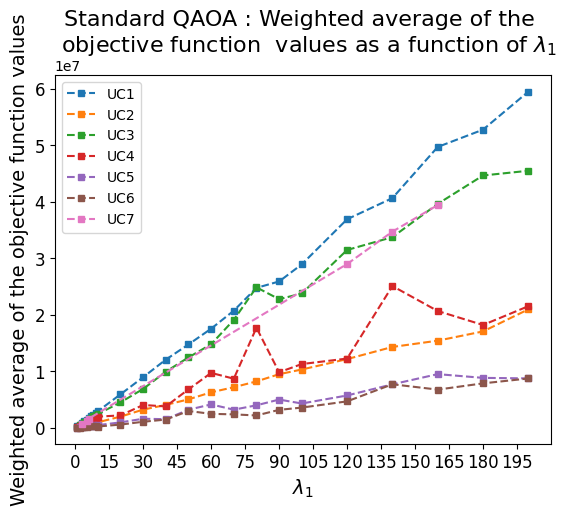

In [70]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

l=[20,20,20,20,20,20,4,10,10]


for i in range(7):
    
    instance_results = results_table.iloc[i*24:(i+1)*24]
    
    if i>=6: filtered_results = instance_results[instance_results['Optimal Solution'] == instance_results['Optimal Solution'].iloc[l[i]]]
        
    else:

        filtered_results = instance_results[instance_results['Optimal Solution'] == instance_results['Optimal Solution'].iloc[-1]]

    ax.plot(filtered_results['Penalty'], filtered_results['Approximation Ratio'], "s--", markersize=4, label = 'UC'+str(i+1))


ax.set_xlabel('$\lambda_{1}$',fontsize=14)
ax.set_ylabel('Weighted average of the objective function values',fontsize=14)
ax.set_title('Standard QAOA : Weighted average of the \n  objective function  values as a function of $\lambda_{1}$ ',fontsize=16)
ax.legend()

plt.xticks(np.arange(0, 200, 15),fontsize=12)
plt.yticks(fontsize=12)
plt.show()

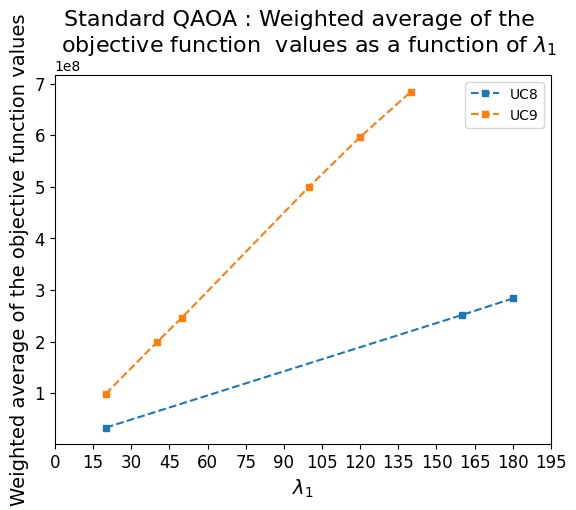

In [71]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

l=[20,20,20,20,20,20,4,10,10]


for i in range(7,9):
    
    instance_results = results_table.iloc[i*24:(i+1)*24]
    
    if i>=6: filtered_results = instance_results[instance_results['Optimal Solution'] == instance_results['Optimal Solution'].iloc[l[i]]]
        
    else:

        filtered_results = instance_results[instance_results['Optimal Solution'] == instance_results['Optimal Solution'].iloc[-1]]

    ax.plot(filtered_results['Penalty'], filtered_results['Approximation Ratio'], "s--", markersize=4, label = 'UC'+str(i+1))


ax.set_xlabel('$\lambda_{1}$',fontsize=14)
ax.set_ylabel('Weighted average of the objective function values',fontsize=14)
ax.set_title('Standard QAOA : Weighted average of the \n  objective function  values as a function of $\lambda_{1}$ ',fontsize=16)
ax.legend()

plt.xticks(np.arange(0, 200, 15),fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [72]:
results_table_2.iloc[18:18*2]['Optimal Solution']

18    0001010010
19    0001010010
20    0001010010
21    0001010010
22    0001010010
23    0001010010
24    1011110001
25    1011110001
26    1011110001
27    1011110010
28    1011110010
29    1011110010
30    1011110010
31    1011110010
32    1011110010
33    1011110010
34    1011110010
35    1011110010
Name: Optimal Solution, dtype: object

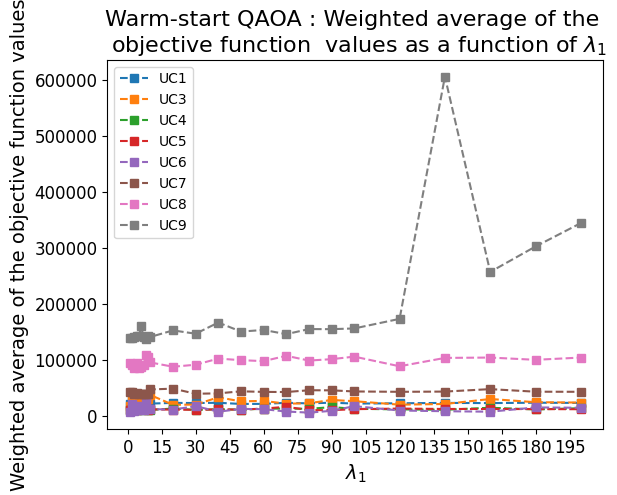

In [73]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for i in range(9):
    if i == 1:pass
    else:
        instance_results = results_table_2.iloc[i*24:(i+1)*24]

        filtered_results = instance_results[instance_results['Optimal Solution'] == instance_results['Optimal Solution'].iloc[-1]]

        ax.plot(filtered_results['Penalty'], filtered_results['Approximation Ratio'], "s--", label = 'UC'+str(i+1))

ax.set_xlabel('$\lambda_{1}$',fontsize=14)
ax.set_ylabel('Weighted average of the objective function values',fontsize=14)
ax.set_title('Warm-start QAOA : Weighted average of the \n objective function  values as a function of $\lambda_{1}$',fontsize=16)
ax.legend()

plt.xticks(np.arange(0, 200, 15),fontsize=12)
plt.yticks(fontsize=12)
plt.show()

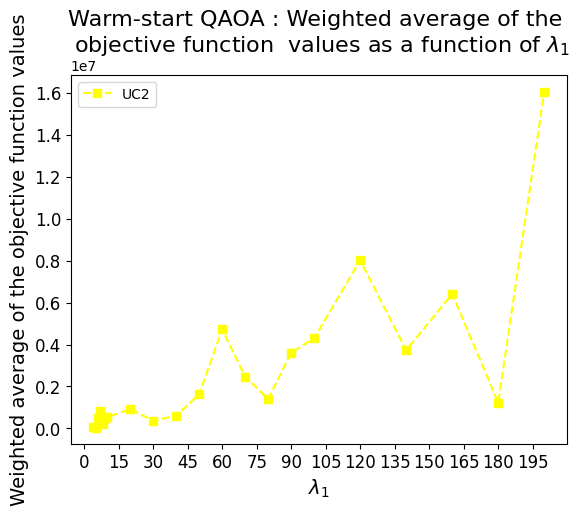

In [74]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for i in range(1, 2):
        instance_results = results_table_2.iloc[i*24:(i+1)*24]

        filtered_results = instance_results[instance_results['Optimal Solution'] == instance_results['Optimal Solution'].iloc[-1]]

        ax.plot(filtered_results['Penalty'], filtered_results['Approximation Ratio'], "s--", label = 'UC'+str(i+1),color='yellow')

ax.set_xlabel('$\lambda_{1}$',fontsize=14)
ax.set_ylabel('Weighted average of the objective function values',fontsize=14)
ax.set_title('Warm-start QAOA : Weighted average of the \n objective function  values as a function of $\lambda_{1}$',fontsize=16)
ax.legend()

plt.xticks(np.arange(0, 200, 15),fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [108]:
# Create a dictionary with the parameters of the UC

UC_dict = {}
UC_dict['pmin'] =  [10,10,20,20,25,150,25,10,150,20]                  # min power
UC_dict['pmax'] =  [55,55,130,130,162,455,85,55,455,80]                 # max power
UC_dict['A'] = [660,670,700,680,450,970,480,665,1000,370]                   # constant cost
UC_dict['B'] = [25.92,27.76,16.6,16.5,19.7,17.26,27.74,27.27,16.19,22.26]             # linear cost
UC_dict['C'] = [0.00413,0.00173,0.002,0.00211,0.00398,0.00031,0.0079,0.00222,0.00048,0.00712]      # quadratic cost
#UC_dict['lambda'] = [5*10^6,5*10^6,5000*10^6]       # penaltys for not respectig total power, max power and min power, respectively
UC_dict['L'] = 1000                                  # load
UC_dict['p'] = [10, 10, 20, 130, 25, 415, 25, 10, 455, 20]                       # power demand of each unit
UC_dict['lambda'] = [3,1,1]       # penaltys for not respectig total power, max power and min power, respectively
UC_dict['s1'] = [UC_dict['p'][i]-UC_dict['pmin'][i] for i in range(len(UC_dict['p']))]   # slack variables for min power                                     
UC_dict['s2'] = [UC_dict['pmax'][i]-UC_dict['p'][i] for i in range(len(UC_dict['p']))] 
UC_dict['units'] = '0001010010'

UC_dict_1 = {}
UC_dict_1['pmin'] =  [150,20,25,20]                   # min power
UC_dict_1['pmax'] =  [455,130,162,80]                 # max power
UC_dict_1['A'] = [1000,700,450,370]                   # constant cost
UC_dict_1['B'] = [16.19,16.5,16.7,22.26]              # linear cost
UC_dict_1['C'] = [0.00048,0.002,0.00398,0.00712]      # quadratic cost
UC_dict_1['lambda'] = [1,1,1]       # penaltys for not respectig total power, max power and min power, respectively
UC_dict_1['L'] = 550                                  # load
UC_dict_1['p'] = [455,20,95,20]                       # power demand of each unit 
UC_dict_1['s1'] = [UC_dict_1['p'][i]-UC_dict_1['pmin'][i] for i in range(len(UC_dict_1['p']))]   # slack variables for min power                                     
UC_dict_1['s2'] = [UC_dict_1['pmax'][i]-UC_dict_1['p'][i] for i in range(len(UC_dict_1['p']))] 
UC_dict_1['units'] = '1010'

UC_dict_2 = {}
UC_dict_2['pmin'] =  [200, 150, 20, 30, 25, 20, 40, 10, 15, 10]                  # min power
UC_dict_2['pmax'] =  [300, 455, 130, 130, 100, 80, 85, 55, 55, 55]                 # max power
UC_dict_2['A'] = [660,670,700,680,450,970,480,665,1000,370]                   # constant cost
UC_dict_2['B'] = [25.92,27.76,16.6,16.5,19.7,17.26,27.74,27.27,16.19,22.26]             # linear cost
UC_dict_2['C'] = [0.00413, 0.00173, 0.002, 0.00211, 0.00398, 0.00031, 0.0079, 0.00222, 0.00048, 0.00712]      # quadratic cost
#UC_dict['lambda'] = [5*10^6,5*10^6,5000*10^6]       # penaltys for not respectig total power, max power and min power, respectively
UC_dict_2['L'] = 800                                  # load
UC_dict_2['p'] = [300, 440, 130, 130, 100, 20, 40, 10, 15,55]                       # power demand of each unit
UC_dict_2['lambda'] = [3,1,1]       # penaltys for not respectig total power, max power and min power, respectively
UC_dict_2['s1'] = [UC_dict_2['p'][i]-UC_dict_2['pmin'][i] for i in range(len(UC_dict_2['p']))]   # slack variables for min power                                     
UC_dict_2['s2'] = [UC_dict_2['pmax'][i]-UC_dict_2['p'][i] for i in range(len(UC_dict_2['p']))]
UC_dict_2['units'] = '0111100000'


UC_dict_3 = {}
UC_dict_3['pmin'] =  [10,10,20,20,25,150,25,10,150,20]                  # min power
UC_dict_3['pmax'] =  [55,55,130,130,162,455,85,55,455,80]                 # max power
UC_dict_3['A'] = [660,670,700,680,450,970,480,665,1000,370]                   # constant cost
UC_dict_3['B'] = [25.92,27.76,16.6,16.5,19.7,17.26,27.74,27.27,16.19,22.26]             # linear cost
UC_dict_3['C'] = [0.00413,0.00173,0.002,0.00211,0.00398,0.00031,0.0079,0.00222,0.00048,0.00712]      # quadratic cost
#UC_dict['lambda'] = [5*10^6,5*10^6,5000*10^6]       # penaltys for not respectig total power, max power and min power, respectively
UC_dict_3['L'] = 900                                # load
UC_dict_3['p'] = [10,10,20,20,25,445,25,10,455,20]                       # power demand of each unit
UC_dict_3['lambda'] = [5,1,1]       # penaltys for not respectig total power, max power and min power, respectively
UC_dict_3['s1'] = [UC_dict_3['p'][i]-UC_dict_3['pmin'][i] for i in range(len(UC_dict_3['p']))]   # slack variables for min power                                     
UC_dict_3['s2'] = [UC_dict_3['pmax'][i]-UC_dict_3['p'][i] for i in range(len(UC_dict_3['p']))] 
UC_dict_3['units'] = '0000010010'

UC_dict_4 = {}
UC_dict_4['pmin'] =  [10,10,25,150]                   # min power
UC_dict_4['pmax'] =  [55,100,85,500]                  # max power
UC_dict_4['A'] = [670,450,735,370]                    # constant cost
UC_dict_4['B'] = [25.92,16.5,16.7,22.26]              # linear cost
UC_dict_4['C'] = [0.00413,0.002,0.00398,0.00712]       # quadratic cost
UC_dict_4['lambda'] = [1,1,1]                        # penaltys for not respectig total power, max power and min power, respectively
UC_dict_4['L'] = 400                                  # load
UC_dict_4['p'] = [10, 100, 85, 215]                       # power demand of each unit 
UC_dict_4['s1'] = [UC_dict_4['p'][i]-UC_dict_4['pmin'][i] for i in range(len(UC_dict_4['p']))]   # slack variables for min power                                     
UC_dict_4['s2'] = [UC_dict_4['pmax'][i]-UC_dict_4['p'][i] for i in range(len(UC_dict_4['p']))]
UC_dict_4['units'] = '0111'


UC_dict_5 = {}
UC_dict_5['pmin'] =  [150,20,25,20]                   # min power
UC_dict_5['pmax'] =  [455,130,162,80]                 # max power
UC_dict_5['A'] = [1000,700,450,370]                   # constant cost
UC_dict_5['B'] = [16.19,16.5,16.7,22.26]              # linear cost
UC_dict_5['C'] = [0.00048,0.002,0.00398,0.00712]      # quadratic cost
UC_dict_5['lambda'] = [30,1,1]       # penaltys for not respectig total power, max power and min power, respectively
UC_dict_5['L'] = 300                                  # load
UC_dict_5['p'] = [300,20,25,20]                       # power demand of each unit 
UC_dict_5['s1'] = [UC_dict_5['p'][i]-UC_dict_5['pmin'][i] for i in range(len(UC_dict_5['p']))]   # slack variables for min power                                     
UC_dict_5['s2'] = [UC_dict_5['pmax'][i]-UC_dict_5['p'][i] for i in range(len(UC_dict_5['p']))]
UC_dict_5['units'] = '1000'

UC_dict_6 = {}
UC_dict_6['pmin'] =  [80,30,60, 60,40,120,130,20,54,170,40,110,130,35,140,200,190,30,70,10]                  
UC_dict_6['pmax'] =  [295,370,580,150,200,500,255,615,350,640,420,220,465,445,416,375,550,80,545,420]
UC_dict_6['A'] = [430,520,785,400,880,435,350,720,930,890,870,860,980,490,725,370,450,840,415,410]
UC_dict_6['B'] = [25.08,22.67,19.82,19.08,19.68,29.95,23.26,18.04,21,24.83,21.25,24.52,15.76,15.11,29.97,20.07,20.55,24.85,23.57,16.05]
UC_dict_6['C'] = [0.00516,0.00656,0.00138,0.00273,0.00408,0.0067,0.00217,0.00197,0.0032,0.00788,0.0023,0.00083,0.00622,0.00311,0.00505,0.00608,0.00105,0.00269,0.00479,0.00048]
UC_dict_6['lambda'] = [30,1,1]
UC_dict_6['L'] = 2000
UC_dict_6['p'] = [80.0, 30.0, 60.0, 150.0, 40.0, 120.0, 130.0, 589.53, 54.0, 170.0, 40.0, 110.0, 395.47, 445.0, 140.0, 200.0, 195, 30.0, 70.0, 420.0]
UC_dict_6['units'] = '00010001000011000001'
UC_dict_6['s1'] = [UC_dict_6['p'][i]-UC_dict_6['pmin'][i] for i in range(len(UC_dict_6['p']))]   # slack variables for min power                                     
UC_dict_6['s2'] = [UC_dict_6['pmax'][i]-UC_dict_6['p'][i] for i in range(len(UC_dict_6['p']))]

UC_dict_7 = {}
UC_dict_7['pmin'] =  [80,30,60, 60,40,120,130,20,54,170,40,110,130,35,140,200,190,30,70,10]                  
UC_dict_7['pmax'] =  [295,370,580,150,200,500,255,615,350,640,420,220,465,445,416,375,550,80,545,420]
UC_dict_7['A'] = [430,520,785,400,880,435,350,720,930,890,870,860,980,490,725,370,450,840,415,410]
UC_dict_7['B'] = [25.08,22.67,19.82,19.08,19.68,29.95,23.26,18.04,21,24.83,21.25,24.52,15.76,15.11,29.97,20.07,20.55,24.85,23.57,16.05]
UC_dict_7['C'] = [0.00516,0.00656,0.00138,0.00273,0.00408,0.0067,0.00217,0.00197,0.0032,0.00788,0.0023,0.00083,0.00622,0.00311,0.00505,0.00608,0.00105,0.00269,0.00479,0.00048]
UC_dict_7['lambda'] = [30,1,1]
UC_dict_7['L'] = 4000
UC_dict_7['p'] = [80, 310.35, 580, 150.0, 194, 120, 130, 615, 54, 170, 420, 110, 465, 445, 140, 355, 550, 30, 70, 420]
UC_dict_7['units'] = '00110001001011011001' 
UC_dict_7['s1'] = [UC_dict_7['p'][i]-UC_dict_7['pmin'][i] for i in range(len(UC_dict_7['p']))]   # slack variables for min power                                     
UC_dict_7['s2'] = [UC_dict_7['pmax'][i]-UC_dict_7['p'][i] for i in range(len(UC_dict_7['p']))]

UC_dict_8 = {}
UC_dict_8['pmin'] =  [80,30,60, 60,40,120,130,20,54,170,40,110,130,35,140,200,190,30,70,10]                  
UC_dict_8['pmax'] =  [295,370,580,150,200,500,255,615,350,640,420,220,465,445,416,375,550,80,545,420]
UC_dict_8['A'] = [430,520,785,400,880,435,350,720,930,890,870,860,980,490,725,370,450,840,415,410]
UC_dict_8['B'] = [25.08,22.67,19.82,19.08,19.68,29.95,23.26,18.04,21,24.83,21.25,24.52,15.76,15.11,29.97,20.07,20.55,24.85,23.57,16.05]
UC_dict_8['C'] = [0.00516,0.00656,0.00138,0.00273,0.00408,0.0067,0.00217,0.00197,0.0032,0.00788,0.0023,0.00083,0.00622,0.00311,0.00505,0.00608,0.00105,0.00269,0.00479,0.00048]
UC_dict_8['lambda'] = [30,1,1]
UC_dict_8['L'] = 6000 
UC_dict_8['p'] = [295,370,580,150,200,120,255,615,350,550, 420,213.67,465,445,140,375,550,30,510,420]
UC_dict_8['units'] = '11111011101011011011'
UC_dict_8['s1'] = [UC_dict_8['p'][i]-UC_dict_8['pmin'][i] for i in range(len(UC_dict_8['p']))]   # slack variables for min power                                     
UC_dict_8['s2'] = [UC_dict_8['pmax'][i]-UC_dict_8['p'][i] for i in range(len(UC_dict_8['p']))]

In [97]:
UC_dicts = [UC_dict,UC_dict_2,UC_dict_3,UC_dict_1,UC_dict_4,UC_dict_5,UC_dict_6, UC_dict_7, UC_dict_8]
penalties2 = [1,7,1,1,1,1,5,20,20]
fval=[]
for i, UC_dict in enumerate(UC_dicts):
        # Run your code or function with the current parameter value
        result1,result2 = aproximation_ratio_penalty_ws(penalties2[i],UC_dict)
        fval.append(result2)

print(fval)

[139345.93599716664, 823134.2579618047, 17455.971407444522, 10948.527285257245, 9834.050644863006, 7614.353267592926, 39550.09880508509, 87763.35550396764, 152616.353944855]


In [109]:
UC_dicts = [UC_dict,UC_dict_2,UC_dict_3,UC_dict_1,UC_dict_4,UC_dict_5,UC_dict_6,UC_dict_7,UC_dict_8]
best_penalty = [5,5,1,10,1,80,3,3,8]
best_AR = []

for i, UC_dict in enumerate(UC_dicts):
        # Run your code or function with the current parameter value
        result1,result2 = aproximation_ratio_penalty_ws(best_penalty[i],UC_dict)
        print(result1,result2)
        best_AR.append(result2)

print(best_AR)

0001010010 19792.445940714406
1011101001 59772.50011225616
0000010010 17455.971407444522
1010 10702.440271615089
0111 9834.050644863006
1000 5902.676743717322
00010001000011000001 38919.50631624844
00110001001011011001 84673.31648369307
11111011101011011011 137134.49649899182
[19792.445940714406, 59772.50011225616, 17455.971407444522, 10702.440271615089, 9834.050644863006, 5902.676743717322, 38919.50631624844, 84673.31648369307, 137134.49649899182]


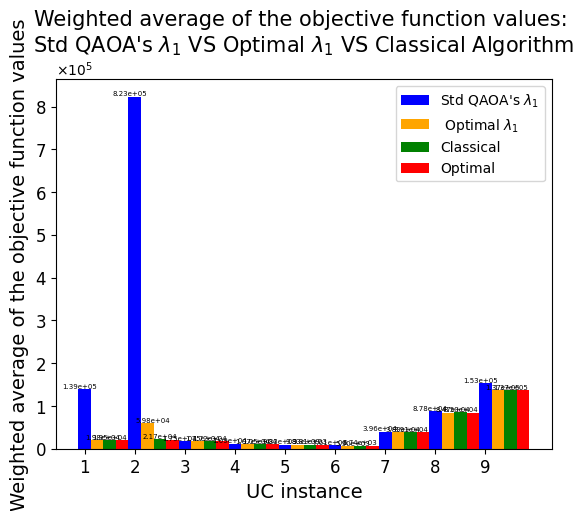

In [110]:
uc_indexes = [0,2,3,1,4,5,6,7,8]
optimal = [19512.77, 21431.59, 17177.91, 10538.24, 9788.28, 5900.20, 38614.08, 83878.69, 136207.65]
classical = [19512.77, 21680.30, 17177.91, 10538.24, 9808.80, 6741.40, 39072.99, 84968.64, 136805.00]
ws_std_p = fval
ws_p =  best_AR

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Assuming you have already loaded the data into the dataframe called df

# Get the index values
index_values = [1,2,3,4,5,6,7,8,9]

# Create a figure and axes
fig, ax = plt.subplots()

# Set the width of each bar
bar_width = 0.25

# Set the x-axis positions for the bars
bar_positions = range(len(index_values))



# Plot the first set of bars
ax.bar(bar_positions, ws_std_p, bar_width, label='Std QAOA\'s $\lambda_{1}$', color='blue')

# Plot the second set of bars, with an offset to overlap
ax.bar([p + bar_width for p in bar_positions], ws_p, bar_width, label=' Optimal $\lambda_{1}$ ', color='orange')
ax.bar([p + bar_width*2 for p in bar_positions], classical, bar_width, label='Classical', color='green')
ax.bar([p + bar_width*3 for p in bar_positions], optimal, bar_width, label='Optimal', color='red')


# Display the values on top of each bar with exponential representation
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(formatter)

for i, v in enumerate(ws_std_p):
    ax.text(i -0.1 , v + 300, f"{v:.2e}", ha='center',va = 'bottom', fontsize=5)

for i, v in enumerate(ws_p):
    ax.text(i + 0.35 , v +300, f"{v:.2e}", ha='center', va='bottom', fontsize=5)

for i, v in enumerate(classical):
    ax.text(i + 2*bar_width , v+ 1 , f"{v:.2e}", ha='center', va='bottom', fontsize=5)

# Set the x-axis tick labels
ax.set_xticks(bar_positions)
ax.set_xticklabels(index_values, fontsize=12)
ax.yaxis.set_tick_params(labelsize=12)


# Set labels and title
ax.set_xlabel("UC instance", fontsize=14)
ax.set_ylabel("Weighted average of the objective function values", fontsize=14)
ax.set_title("Weighted average of the objective function values: \nStd QAOA's $\lambda_{1}$ VS Optimal $\lambda_{1}$ VS Classical Algorithm", fontsize=15)



# Add legend
ax.legend()

# Display the plot
plt.show()

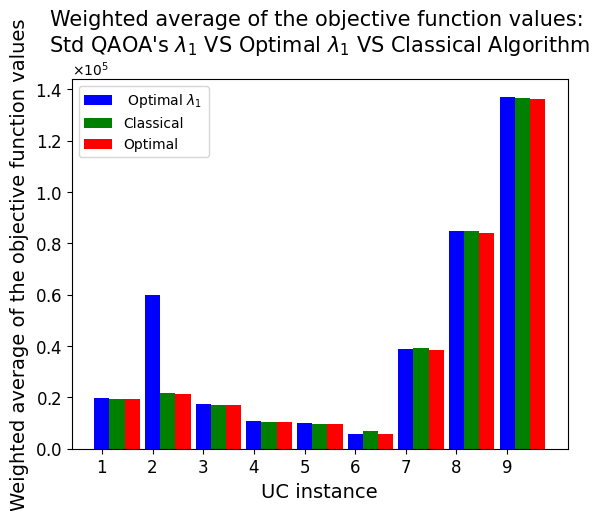

In [111]:
uc_indexes = [0,2,3,1,4,5,6,7,8]
optimal = [19512.77, 21431.59, 17177.91, 10538.24, 9788.28, 5900.20, 38614.08, 83878.69, 136207.65]
classical = [19512.77, 21680.30, 17177.91, 10538.24, 9808.80, 6741.40, 39072.99, 84968.64, 136805.00]
ws_std_p = fval
ws_p =  best_AR

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Assuming you have already loaded the data into the dataframe called df

# Get the index values
index_values = [1,2,3,4,5,6,7,8,9]

# Create a figure and axes
fig, ax = plt.subplots()

# Set the width of each bar
bar_width = 0.3

# Set the x-axis positions for the bars
bar_positions = range(len(index_values))


# Plot the second set of bars, with an offset to overlap
ax.bar(bar_positions, ws_p, bar_width, label=' Optimal $\lambda_{1}$ ', color='blue')
ax.bar([p + bar_width for p in bar_positions], classical, bar_width, label='Classical', color='green')
ax.bar([p + bar_width*2 for p in bar_positions], optimal, bar_width, label='Optimal', color='red')


# Display the values on top of each bar with exponential representation
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(formatter)


# Set the x-axis tick labels
ax.set_xticks(bar_positions)
ax.set_xticklabels(index_values, fontsize=12)
ax.yaxis.set_tick_params(labelsize=12)


# Set labels and title
ax.set_xlabel("UC instance", fontsize=14)
ax.set_ylabel("Weighted average of the objective function values", fontsize=14)
ax.set_title("Weighted average of the objective function values: \nStd QAOA's $\lambda_{1}$ VS Optimal $\lambda_{1}$ VS Classical Algorithm", fontsize=15)



# Add legend
ax.legend()

# Display the plot
plt.show()